# Explore the classification results

This notebook will guide you through different visualizations of the test set evaluation of any of the presented models.

In a first step you can select the result file of any of the models you want to explore.

In [1]:
model = 'vgg_results_sample.csv' #should be placed in the /eval/ folder

Then we will import some packages and setup some basic variables

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread
from sklearn.metrics import accuracy_score, confusion_matrix
from utils import plot_confusion_matrix, class_names, plots

%matplotlib inline

# get the path of the data and eval folder
root_dir = os.path.abspath(os.path.join(sys.path[0], os.pardir))
eval_dir = os.path.join(root_dir, 'eval')
data_dir = os.path.join(root_dir, 'data')

**Next** we will load the evaluation results and compute different **accuracy** values.

1. The per-image accuracy. Should not be be confused with the per-fish accuracy. The per-image accuracy means how many of the samples (image + corresponding features) in the test set were predicted with the correct class.
2. The per-fish accuracy if the results of the different images of one fish are combine by the `mode` of the single image predictions
3. The per-fish accuracy if the final prediction is derived from the class with the highest overall probability if we sum up all class probabilities of the single images.

To get the different per-fish accuracies we can group the data by `video_name` and `label` because each combination of `video_name` and `label` stays for one individual fish. 
The columns `prediction_max_prob` and `prediction_mode` contain the predicted class label for each individual fish derived through the above stated methods. 

In [3]:
#load the evaluation data
df = pd.read_csv(os.path.join(eval_dir, model), sep=';')

#compute the per-image accuracy
acc_per_img = accuracy_score(df['label'], df['pred'])

# get the per-fish results by grouping the dataframe and taking first entry of each group as the columns for the 
# per-fish prediction are the same for all images of one fish
fish = df.groupby(['video_name', 'label']).first().reset_index()

# calculate the per-fish accuracies
acc_fish_mode = accuracy_score(fish['label'], fish['prediction_mode'])
acc_fish_max_prob = accuracy_score(fish['label'], fish['prediction_max_prob'])

# print the results
print("From a total of %i images, %.2f percent of the images were classified correctly." %(len(df), acc_per_img*100))
print("If combined by the mode of %i fish individuals %.2f were classified correctly." %(len(fish), acc_fish_mode*100))
print("If derived from the max probability of the summed class probabilities, out of %i fish %.2f were classified correctly." %(len(fish), acc_fish_max_prob*100))

From a total of 1053 images, 86.32 percent of the images were classified correctly.
If combined by the mode of 104 fish individuals 90.38 were classified correctly.
If derived from the max probability of the summed class probabilities, out of 104 fish 89.42 were classified correctly.


As we are interested in the per-fish accuracy, we can see that combining the classification results of many images of one fish can help to raise the overall prediction accuracy. From the two different methods, this can be best done through the `prediction_max_prob` method.

**Next** we will display the **confusion matrix**. The confusion matrix displays the true class vs. the predicted class. This might help to understand which classes the model can seperate and between which it makes the most mispredictions. 
By changing the first line, you can select which confusion matrix should be displayed. You can chose between ['pre-img', 'mode', 'max_prob'] referring to the 3 different accuracies from above.

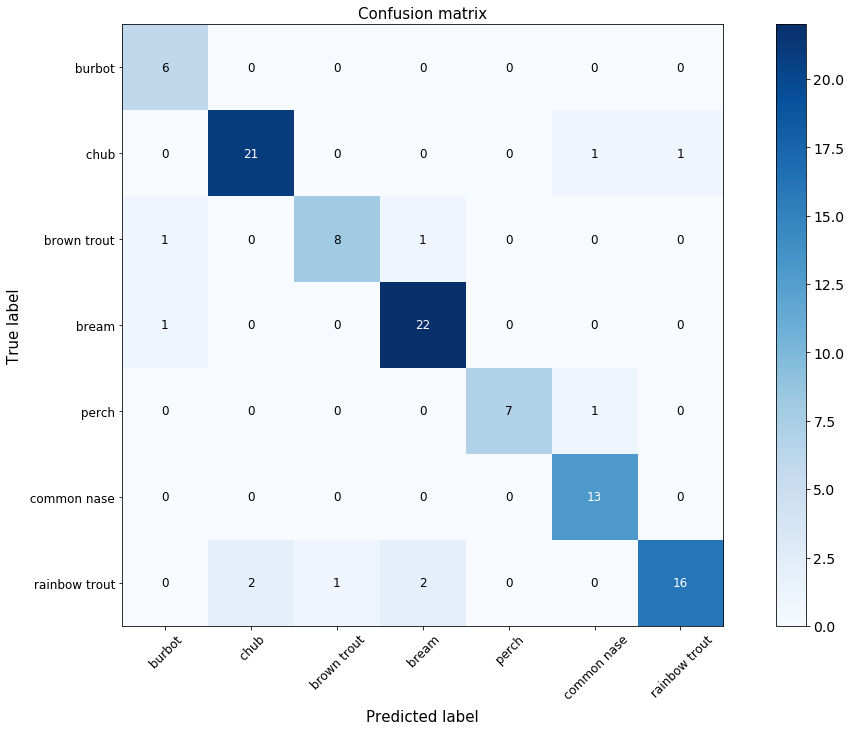

In [4]:
method = 'max_prob' # chose one of ['per-img', 'mode', 'max_prob']

#compute confusion matrix
if method == 'per-img':
    cm = confusion_matrix(df['label'], df['pred'])
elif method == 'mode':
    cm = confusion_matrix(fish['label'], fish['prediction_mode'])
elif method == 'max_prob':
    cm = confusion_matrix(fish['label'], fish['prediction_max_prob'])
else:
    raise ValueError("Select a valid method. Must be one of ['per-img', 'mode', 'max_prob']")
    
#plot confusion matrix
plot_confusion_matrix(cm, [n.split(',')[1] for n in class_names])


You will see for all of the combinations you can selected (4 models and 3 different methods) that the models make the most number of misclassifications between similar (at least somehow) looking fish species. For example you can see that most misclassifications of brown trouts were made with rainbow trouts (and vice versa) and the same for chub and common nase. Through this we can conclude that the models understand the content of the images/features they are confronted with.

**Next** we will look at some random images of each class the model was absolutely sure about it's prediction and the predicted class was indeed the true class.

Found 64 correct Lota lota, burbot, Aalrutte
Found 160 correct Squalius cephalus, chub, Aitel
Found 208 correct Salmo trutta, brown trout, Bachforelle
Found 181 correct Abramis brama, bream, Brachse
Found 65 correct Perca fluviatilis, perch, Flussbarsch
Found 112 correct Chondrostoma nasus, common nase, Nase
Found 119 correct Oncorhynchus mykiss, rainbow trout, Regenbogenforelle


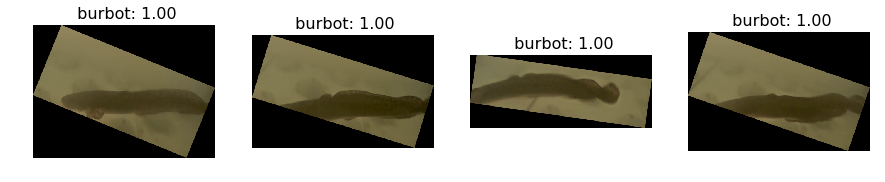

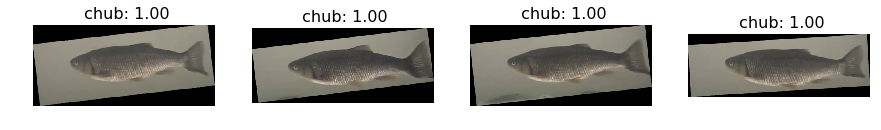

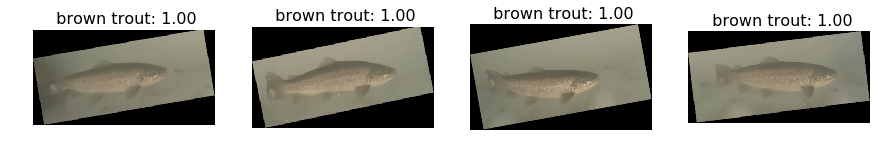

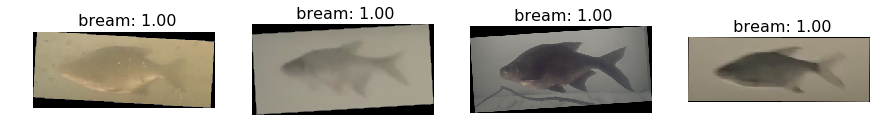

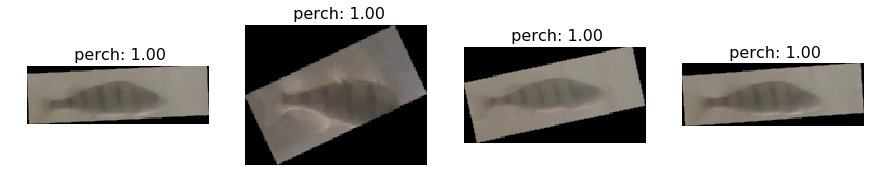

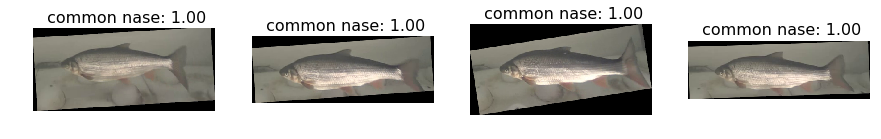

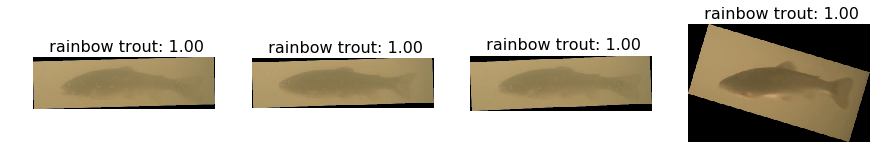

In [5]:
#number of total classes and images per class we will plot
num_classes = 7
n_view = 4

#iterate over each class and find the images the model assigned the highest class probability to (to the true class)
for i in range(num_classes):
    corrects = np.where((df['label'] == i) & (df['pred'] == i))
    df_corrects = df.loc[corrects]
    df_corrects.sort_values('score'+str(i), inplace = True, ascending = False)
    
    #print number of correct images per class
    print("Found %i correct %s" %(len(df_corrects), class_names[i]))
    
    #plot images
    plots(df_corrects, df_corrects.index[:n_view], data_dir)

To some degree, these images should make sense. Most of them show specific characteristics of each species that are enought to classify them correctly. Some might not make much sense for us as a human observer but might make sense to the model. 
E.g. We had plenty of rainbow trouts in turbid water, so that the model seems to have learned that a salmonide looking fish in turbid water is more likely to be a rainbow than a brown trout.

Up **Next** we could visualize the opposite: We could look at the images of each class, for which the model was most uncertain about.

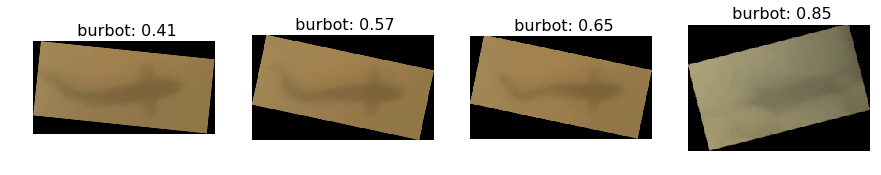

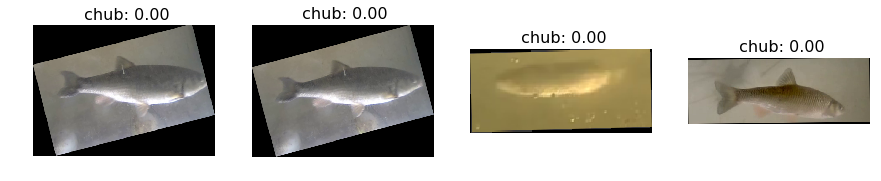

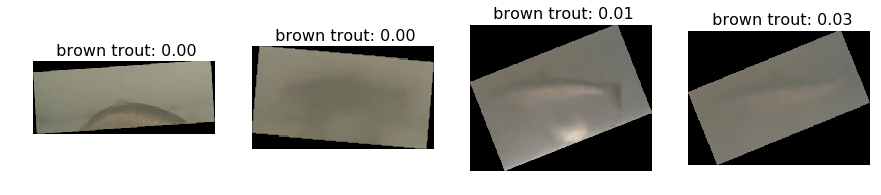

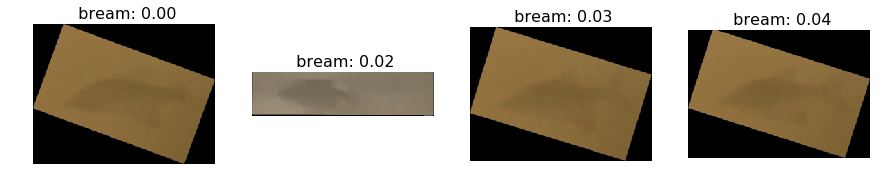

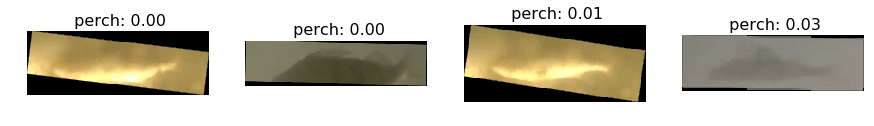

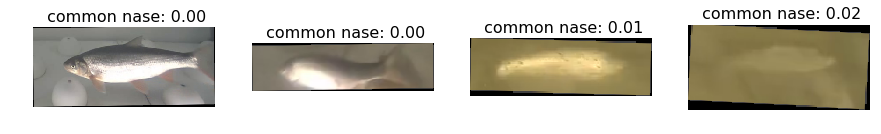

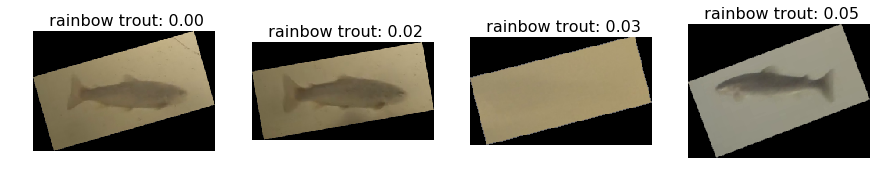

In [6]:
for i in range(num_classes):
    fish = df.loc[df['label'] == i]
    fish.is_copy = False
    fish.sort_values('score'+str(i), inplace = True, ascending = True)
    plots(fish, fish.index[:n_view], data_dir)

These results may let you wonder, why for some of these images the model predicted the wrong class, although the fish could be clearly seen. To be honest, I don't know the answer and could only guess for some of the cases. I think one key point could be the size of the dataset and one could expect that a bigger sample size per class could yield better results. 

One the other hand, one could also see many images of bad quality, turbid water etc. where even for us humans it might be hard to classify the fish by this one single images.

Also note, that this are per-image prediction results. A lot of these single image misclassifications aren't influencing the per-fish predictions. 